# Kohonen maps on hand-written digits

- use data given by name2digits functions
- Kohonen network
    - 6x6 unit distance grid,
    - gaussian neighbordhood with constant std 3
    - small constant learning rate
    - report "how you decide when your algorithm has converged"
- visualize your prototypes and describe result
- find a way to assign one digit to each prototype
- explore 
    - different sizes of map (at least 3, not less than 36 units)
    - explore different width of neighborhood function
    - describe "role of witdth"
    - does the optimal width depend on map size?
- start with large learning rate, reduce it over time, any improvements?
- report (max. 4 pages)
    - choice of learning rate, description on convergence detection
    - visualization, description of learnt prototypes
    - visualization, description of digit-prototype assignment
    - results of network sizes and width exploration, discussion
    - results of varying width of neighborhood over time, discussion

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from helpers import name2digits
plt.rcParams['figure.figsize'] = (16, 6)

In [2]:
digits = name2digits('nicolas+teo')
digits

array([1, 2, 6, 8], dtype=uint8)

In [3]:
labels = np.loadtxt('labels.txt', dtype=np.int)
labels.shape

(5000,)

In [4]:
data = np.loadtxt('data.txt', dtype=np.int)
data.shape

(5000, 784)

In [5]:
data = data[np.in1d(labels, digits), :]

In [6]:
dim = 28 * 28
data_range = 255

In [7]:
def neighborhood(x, mean, std):
    """Normalized neighborhood gaussian-like with mean and std."""
    return np.exp(- np.square(x - mean) / (2 * np.square(std)))

In [8]:
def som_step(centers, datapoint, neighbor, eta, sigma):
    """Learning step self-organized map updating inplace centers.
         centers   (matrix) cluster centres (center X dimension)
         datapoint (vector)
         neighbor  (matrix) coordinates of all centers
         eta       (scalar) learning rate
         sigma     (scalar) width/variance of neighborhood function
    """    
    k = np.argmin(np.sum(np.square(centers - datapoint), axis=1))
    k_coords = np.array(np.nonzero(neighbor == k))
        
    for j in range(len(centers)):
        j_coords = np.array(np.nonzero(neighbor == j))
        disc = neighborhood(np.linalg.norm(k_coords - j_coords), 0, sigma)
        centers[j, :] += disc * eta * (datapoint - centers[j,:])

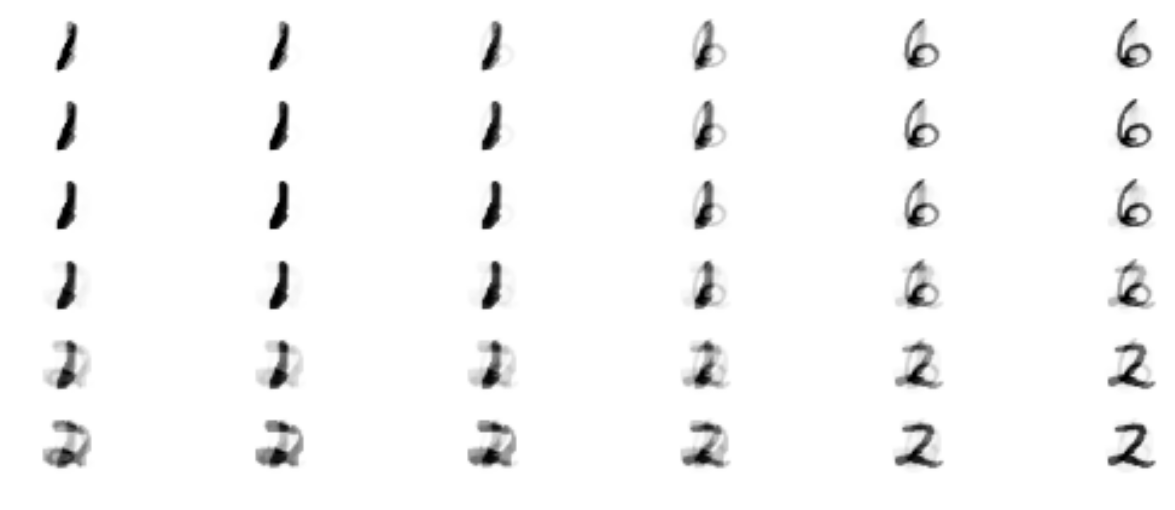

In [9]:
# Kohonen map border size
size_k = 6
# width/variance of neighborhood function
sigma = 2.0

# centers randomly initialized
centers = np.random.rand(size_k ** 2, dim) * data_range

# neighborhood matrix
neighbor = np.arange(size_k ** 2).reshape((size_k, size_k))

# learning rate
eta = 0.9

# maximal iteration count
tmax = 5000

# random order in which the datapoints should be presented
i_random = np.arange(tmax) % len(data)
np.random.shuffle(i_random)

for t, i in enumerate(i_random):
    som_step(centers, data[i, :], neighbor, eta, sigma)

# for visualization, you can use this:
for i in range(size_k ** 2):
    plt.subplot(size_k, size_k, i + 1)
    plt.imshow(centers[i,:].reshape([28, 28]), interpolation='bilinear', cmap='Greys')
    plt.axis('off')

# leave the window open at the end of the loop
plt.show()